# Term deposit marketing
## Background
We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

## Data description
The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**Attributes:**
- age : age of customer (numeric)
- job : type of job (categorical)
- marital : marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

**Output (Desired target)**
- y - has the client subscribed to a term deposit? (binary)

**Download data**
- https://drive.google.com/file/d/1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7

## Goals
- Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

## Success metric(s)
- Hit 81% or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

## Bonus(es)

- We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.
- What makes the customers buy? Tell us which feature we should be focusing more on.


# Data Wrangling
## Imports
Place imports at the start of the notebook so that you only need to consult one place to check your notebook dependencies.

In [3]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import os
import random
# Lazy predict import
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold,learning_curve

from sklearn.metrics import r2_score,classification_report,accuracy_score,roc_curve,roc_auc_score,confusion_matrix,f1_score
from sklearn.model_selection import StratifiedKFold,cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import ExtraTreesClassifier
from seaborn import heatmap
from imblearn.under_sampling import RandomUnderSampler


**Load the telemarketing data**

In [4]:
#df = pd.read_csv('bank-full.csv')

# set a path variable to the directory containing bank telemarketing data:. ../raw_data
path = '../raw_data'
# Concatenate directory path to the file name: bank_path
tele_path = path + '/term-deposit-marketing-2020.csv'
# Load data file to a dataframe: df
df = pd.read_csv(tele_path)

## View and inspect data

In [5]:
# Get number of rows and columns of our dataset: df.shape
df.shape

(40000, 14)

Our dataset consists of 40000 observations and 14 columns. In other words the bank contacted 40000 customers recording 14 attributes for each customer

In [6]:
# view first few customer data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [7]:
#Call the info method on df to see a summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


From the summary of our data we see that we have 5 feature of type integer and 9 categorical features. Also it looks like we do not have any missing values in our dataset. All 40000 observation are non-null.

## Count number of missing values (double check)
Let's explicitly get the number of missing values in each column of our data

In [8]:
# Count (using `.sum()`) the number of missing values (`.isnull()`) in each column of df
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

We do not have any missing values in our data. However, it must be noted that isnull() is not the only indicator of missing data. Sometimes 'missingness' can be encoded, perhaps by a -1 or 999. Such values are typically chosen because they are "obviously" not genuine values. We will find out later if we have encoded missing values later, but for now at least we know that we do have any missing values or `nan` values in any of our columns.

## Check for duplicates in our data
Let's check for duplicates in our dataset if we have any.

In [9]:
#count the number of duplicate observation in df
df.duplicated().sum()

0

We also do not have any duplicate entries in our dataset.

## Explore the data

Let us now explore the data more closely. We can start exploring with categorical features and then explore the numerical features.

### Categorical features

Let us explore the categorical features.

In [10]:
# create a list containig categorcal feature names
categorical_features = list(df.select_dtypes('object').axes[1])
print(categorical_features)
len(categorical_features)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']


9

Consistent with what we obtained from .info() method, we have 9 categorical features.

### How many unique values does each categorical feature has?
Let's get the number of unique values for each of the categorical features 

In [11]:
# use pandas .nunique() method to get the count of unique values for each categorical feature.
df[categorical_features].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        11
y             2
dtype: int64

While 7 of the categorical features have unique value counts of less than or equal to 4, two feature namely: `job` and `month` have 12 and 11 unique values. Note that the not all the 12 months are present in the dataset, since we only have 11 unique values. We need to check this

In [12]:
# check which month might be missing
df['month'].value_counts().index

Index(['may', 'jul', 'aug', 'jun', 'nov', 'apr', 'feb', 'jan', 'mar', 'oct',
       'dec'],
      dtype='object')

No telemarketing data for september. For some reason, the bank did not conduct any telemarketing campaign during the month of september.

### Group categorical features

The categorical features can be grouped into three categories, namely. 1. Demographic features 2. financial features 3. campaign and target categorical feature group

In [13]:
# create lists consisting group of categorical features
demographic_cat_features = ['job', 'marital', 'education']
financial_cat_features = ['default', 'housing', 'loan']
campaign_and_target_cat_features = ['contact', 'month','y']

In [14]:
# Function for plotting multiple categorical features
# It specifically plots customers segmented by demographics, financial data, and campaingn details
def plot_categorical_features(data_frame,features_list):
        total = len(data_frame)
        axes = []
        i=0
        while(i<len(features_list)):
            # create subplots
            sns.set(font_scale=1.4)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            fig.set_size_inches(14, 6)
        
            if features_list[i] in demographic_cat_features:
                label = 'Demographic'
            if features_list[i] in financial_cat_features:
                label = 'Financial data segmented'
            if features_list[i] in campaign_and_target_cat_features:
                label = 'Previous and past campaign result segmented'
            fig.suptitle(label + ' distribution of customers contacted' , fontsize=22)
            plt.tight_layout()
            
            sns.countplot(y= data_frame[features_list[i]] , palette=['red','blue'], ax=ax1,hue=data_frame['y'])
    
            sns.countplot(y= data_frame[features_list[i+1]] , palette=['red','blue'], ax=ax2,hue=data_frame['y'])
            
            sns.countplot(y= data_frame[features_list[i+2]] , palette=['red','blue'], ax=ax3,hue=data_frame['y'])
            ax1.set_title('Contact count by '+ features_list[i],fontname='Comic Sans MS', fontsize=18)
            
            
            ax2.set_title('Contact count by ' + features_list[i+1],fontname='Comic Sans MS', fontsize=18)
            ax3.set_title('Contact count by ' + features_list[i+2],fontname='Comic Sans MS', fontsize=18)
            
            ax1.set_ylabel(features_list[i], fontsize=20)
            ax2.set_ylabel(features_list[i+1], fontsize=20)
            ax3.set_ylabel(features_list[i+2], fontsize=20)
            #ax1.set_yticklabels('labels',fontsize=20)
          #  ax2.set_ylabel(features_list[i+1], fontsize=20)
          #  ax3.set_ylabel(features_list[i+2], fontsize=20)
            ax1.set_xlabel('Count', fontsize=20)
            ax2.set_xlabel('Count', fontsize=20)
            ax3.set_xlabel('Count', fontsize=20)
            
            i+=3
            
            axes.append(ax1)
            axes.append(ax2)
            axes.append(ax3)

        return axes
    

In [15]:
# Group data frame into two groups based on target value
df_group_by_target = df.groupby('y')
for target,df_group in df_group_by_target:
    if target == 'yes':
        df_subscribed = df_group
    if target == 'no':
        df_unsubscribed = df_group

In [16]:
# Function to create a new dataframe consisting of value counts of a given categorical features 
# along with counts of subscribed, unsubscribed, total, and percent subscribed for a given value of
# a catgorical feature
# function returns a dictionary of dataframes with keys corresponding to categorical features input
# in the argument of the function as a list.
def create_df_sub(cat_features):
#    i = 0
    dict_df_sub = {}
#    while i <= len(cat_features):
    for feature in cat_features:   
        temp1 = df_subscribed[feature].value_counts()
        temp2 = df_unsubscribed[feature].value_counts()
        df1 = pd.concat([temp1,temp2],axis=1)
        df1.columns = ['Subscribed', 'Not Subscribed']
        total = df1['Subscribed'] + df1['Not Subscribed']
        df1['Total'] = total
        df1['% Subscription'] = (df1['Subscribed']/df1['Total'])*100
        dict_df_sub[feature] = df1
    return dict_df_sub

#### Demographic distribution of customers

Demographic segmentation is a systematic gouping of customers into distinct groups for the purpose of marketing. Effective marketing communication requires the identification of the right target group. Demographic segmentation is a commonly used technique in marketing where target categories based on one or more of socio-economic variables like job, age, gender, marital status, income, eduction, etc. In our case the categorical demongraphic content of the customers contacted by the bank includes `job`, `marital`, `education`. 

It is important to know the demographic content of the customers the bank has reached out during its campaign before determining how predictive a given demographic trait is in determining whether a customer will subscribe to a term deposit or not. Figure below shows the demographic distribution of customers contacted by the bank irrespective of whether they have subscribed or not. 

In [17]:
# call function above (create_df_sub) with an argument ['job'], ['marital'], and ['contact'] 
# to get a dictionary whose value is a dataframe corresponding
# dict['job'] = dataframe (consisting of subscribed, unsubscribed, %, and total)

#Dictionaries for job, contact, and marital
dict_df_job = create_df_sub(['job'])
dict_df_marital = create_df_sub(['marital'])
dict_df_education = create_df_sub(['education'])
#dataframes for each category
df_jobs = dict_df_job['job']
df_marital = dict_df_marital['marital']
df_education = dict_df_education['education']
#Combine datframes
pd.concat([df_jobs, df_marital, df_education], keys=['Job', 'Marital', 'Education'],sort=True)

% Subscription  Not Subscribed  Subscribed  Total
Job       management               8.28            7490         676   8166
          blue-collar              5.70            8848         535   9383
          technician               7.25            6355         497   6852
          admin                    7.83            4132         351   4483
          services                 6.09            3672         238   3910
          retired                 10.51            1286         151   1437
          self-employed            7.92            1302         112   1414
          unemployed               8.70            1008          96   1104
          entrepreneur             6.26            1317          88   1405
          student                 15.65             442          82    524
          housemaid                4.88            1034          53   1087
          unknown                  7.23             218          17    235
Marital   married                  6.06           22908        1478  24386
          single                   9.43            9862        1027  10889
          divorced                 8.28            4334         391   4725
Education secondary                6.75           19575        1418  20993
          tertiary                 9.18           10177        1029  11206
          primary                  5.63            5917         353   6270
          unknown                  6.27            1435          96   1531

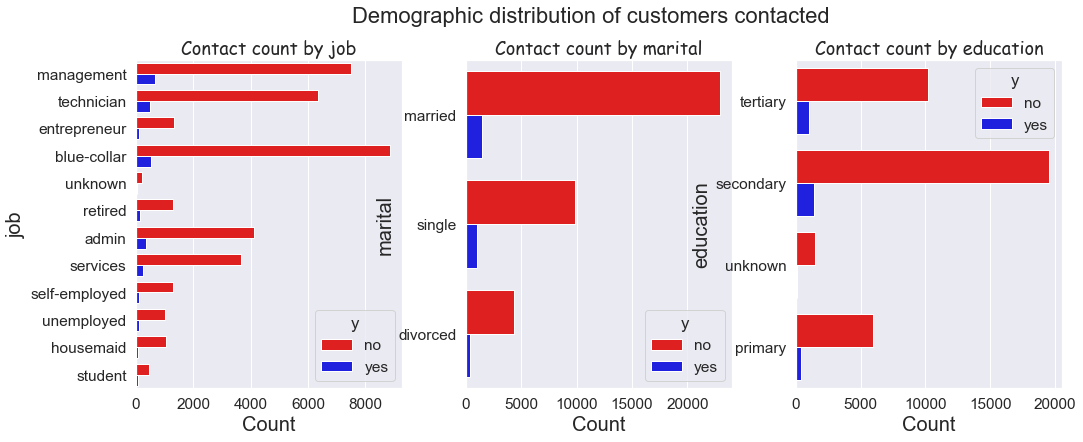

In [18]:
# Use function above to plot demographic content of customers contacted by the bank during the telemarketing.
plot_categorical_features(df,demographic_cat_features);

##### Customer jobs
Customers with `blue-collar` jobs were contacted the most during the marketing campaing. Customer's whose jobs is unknown (either not recroded or customer did not want to speficity) are targeted the least during the marketing campaign. Following customers with blue-collar managers, technicians, and adminstrators, respectively in decreasing order were contacted during the marketing compaign. As one might expect students were targeted the least during the marketing compaign. Though the bank contacted the largest number of people in job segment category of `blue-collar`, and the number of students the bank contacted was small, the percentage of students who subscribed to term deposit is the largest. We recommend the bank contact more students in the next telemarketing campaign.

##### Marital status

`Marital status` is another important trait used in demographic segmentaion. It provides useful information to target audience during marketing communication through promotional messages. Usually people in the same marital status group have common tastes and can can be easily targeted based on marital status. For example, generally people who are married need more financial strategy and are likely expected to respond to the term deposit marketing campaign.
The largest number of people contacted during the marketing campaing are `married`. The list contacted people are `divorced`individuals.  However, the rate of subscription for divorced people is also greater than that of married people. We recommend the bank target more single and divorced people in its next telemarketing campaign for term deposit subscription.

##### Educational level
The level of education of an individual is also an important trait when segmenting population for marketing campaigns. For example educational level determines determines the choice of communication channel in passing across your message.
During the marketing campaign customer who completed high school are contacted the most. There are also a few number of contacts made where customer's education level is `UNKNOWN`. 

#### Financial distribution of customers

In addition to demographic segmentation, customers could be grouped together based on their account related to their finances. That is whether a customer has credit or not (`default`), has housing loan or not (`housing`), and has personal loan or not (`loan`).  Below we plot the distribution of customers segmented by their fiancail status. 

In [19]:
dict_df_default = create_df_sub(['default'])
dict_df_housing = create_df_sub(['housing'])
dict_df_loan = create_df_sub(['loan'])
#dataframes for each category
df_default = dict_df_default['default']
df_housing = dict_df_housing['housing']
df_loan = dict_df_loan['loan']
#Combine datframes
pd.concat([df_default, df_housing, df_loan], keys=['default', 'Housing', 'Loan'],sort=True)

% Subscription  Not Subscribed  Subscribed  Total
default no             7.26           36344        2847  39191
        yes            6.06             760          49    809
Housing yes            6.09           22567        1464  24031
        no             8.97           14537        1432  15969
Loan    no             7.61           30554        2516  33070
        yes            5.48            6550         380   6930

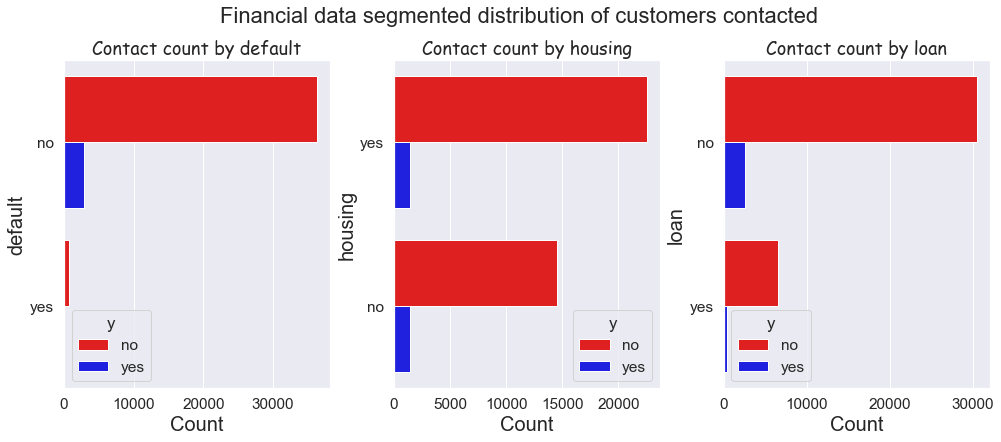

In [20]:
# plot financial segmented distribution
plot_categorical_features(df,financial_cat_features);

##### Has credit (`default`)
Majority of customers contacted by the bank do not have credit or did not default (98.2%). Only a few fraction (1.8%) of all the customers contacted had credit. Hence, credit might not be an important feature in determining whether a customer will subscribe to a term deposit or not. 

##### Housing loan
During this telemarketing campaign, the bank called an almost balanced number of customers depending whether they have housing loan or not. About 55% of the customers contacted by the bank during this telemarketing possess housing loan. The remaining about 45% of the customers contacted did not have housing loan.

##### Personal loan

The majority of customers (84%) called during this telemarketing did not have any personal loans. However, a non-negligible number of customers (16%) had personal loans.

#### Distribution of customers versus camapaign details and target balance plot

In addition to demographic and financial segmentation, customers could be grouped together based on the details of the past and present campaign parameters.  That is how was the customer contacted (for example iphone or phone), the particular month the cusomter was contacted. 

Below we plot customers segmented by details of the past and present campaing.

In [21]:
# call function above (create_df_sub) with an argument ['job'], ['marital'], and ['contact'] 
# to get a dictionary whose value is a dataframe corresponding
# dict['job'] = dataframe (consisting of subscribed, unsubscribed, %, and total)

#Dictionaries for job, contact, and marital
dict_df_contact = create_df_sub(['contact'])
dict_df_month = create_df_sub(['month'])
dict_df_target = create_df_sub(['y'])
#dataframes for each category
df_contact = dict_df_contact['contact']
df_month = dict_df_month['month']
df_target = dict_df_target['y']
#Combine datframes
pd.concat([df_contact, df_month,df_target], keys=['Contact', 'Month','Target'],sort=True)

% Subscription  Not Subscribed  Subscribed    Total
Contact cellular             8.96        22681.00     2233.00 24914.00
        unknown              3.89        12268.00      497.00 12765.00
        telephone            7.15         2155.00      166.00  2321.00
Month   may                  5.85        12741.00      791.00 13532.00
        apr                 16.59         2267.00      451.00  2718.00
        jul                  6.02         5996.00      384.00  6380.00
        jun                  6.21         4440.00      294.00  4734.00
        aug                  5.52         4927.00      288.00  5215.00
        feb                 11.11         2041.00      255.00  2296.00
        nov                  6.11         3378.00      220.00  3598.00
        mar                 48.45          133.00      125.00   258.00
        oct                 61.25           31.00       49.00    80.00
        jan                  3.23         1138.00       38.00  1176.00
        dec                  7.69           12.00        1.00    13.00
Target  yes                   nan             nan     2896.00      nan
        no                    nan        37104.00         nan      nan

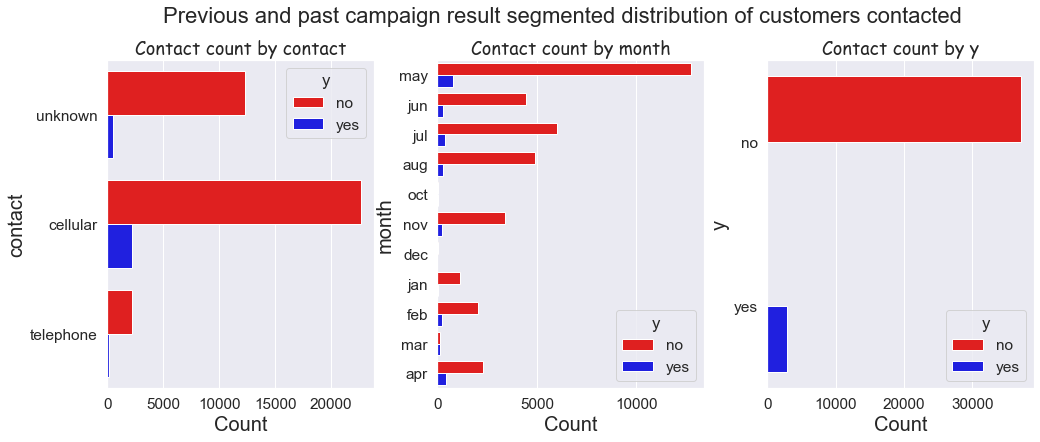

In [22]:
# plot distribution of customers versus campaign details and target balance
plot_categorical_features(df,campaign_and_target_cat_features);

##### Contact
Different segments of the populations prefer different methods of contact. The communication channel used during the marketing campaign is essential. The largest number of customers were contacted through cellular phone. The least popular method of contact was through telephone. During the marketing campaign, 62% of the population contacted by the bank was through cellualr phones. Only 6% contacted through a telephone line while about 32% contacted through an unknown (unspecified) mode of communication. 

##### Season customer contacted
The season when the bank should contact target population segment is also an important trait for the success of the marketing camapaign. The largest number of contacts were made during spring and summer seasons with combined contact rate of 79 %. This is understandable since spring and summer are the beginning and end dates of the tax season; where customers may be motivated for financial plans due to expected tax returns. Barely any telemarketing was conducted during the winter which is understandable as it is the holiday and end of year season.

##### Target balance
With only 7.24% subscribed and 92.76% unsubscribed customers our dataset is highly imbalanced. We might need to deal with balancing the dataset when we are ready to develop the classification machine learning model. 

### Numerical features

Let us now explore the numerical features.

In [23]:
# create a list containig categorcal feature names
numerical_features = list(df.select_dtypes('int64').axes[1])
print(numerical_features)
len(numerical_features)

['age', 'balance', 'day', 'duration', 'campaign']


5

In [24]:
# plot the distribution of numerical columns using histograms
def plot_distribution(df,columns,plot_type='boxplot'):
    sns.set()
    axes = []
    i=0

    while i<len(columns):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        #sns.hisplot(df[columns[i]],bins=15,color='blue',ax=ax1)
        sns.boxplot(df[columns[i]],color='blue',ax=ax1,hue=df['y'])
        ax1.set_xlabel(columns[i], fontsize=20)
        ax1.set_ylabel('Count', fontsize=20)
        try:
            #sns.histplot(df[columns[i+1]],bins=15,color='blue',ax=ax2)
            sns.boxplot(df[columns[i+1]],color='blue',ax=ax2,hue=df['y'])
            ax2.set_xlabel(columns[i+1], fontsize=20)
            ax2.set_ylabel('Count', fontsize=20)
#            ax2.set(xlim=(-9000,100000))
        except:
            print('Warning: Odd number of variables provided. One plot will be empty')
        i+=2
        axes.append(ax1)
        axes.append(ax2)
    return axes

#### Age and balance
Let us see the distribution of customers by age and by how much balance they have in their account

            age   balance
count  40000.00  40000.00
mean      40.54   1274.28
std        9.64   2903.77
min       19.00  -8019.00
25%       33.00     54.00
50%       39.00    407.00
75%       48.00   1319.00
max       95.00 102127.00
median    39.00    407.00


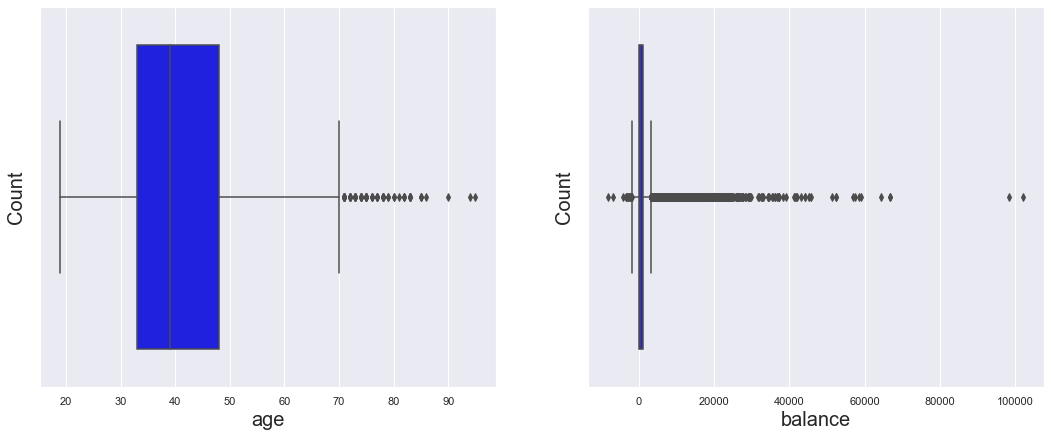

In [25]:
# Create dataframe containing stastistical summary of numerical features
stat_summary_numericals = df[numerical_features].describe()
stat_summary_numericals.loc['median'] = df[numerical_features].median()
print(stat_summary_numericals[['age','balance']].head(12))
# create list consisting of age and balance
numerical_age_balance = ['age','balance']

# plot histogram of age and balance
plot_distribution(df,numerical_age_balance);

##### Distribution of age 

The age of customers contacted by the bank during the telemarketing extends from a minium age of 18 years to a maximum age of 95 years old. The majority of customer contacted by the bank were in their 30s and 40s (33 to 48 years land within 25th and 75 th percentiles). With an average age of 41 years old and a standard deviation of 10 years, the distribution of age is close to normal distribution.  

##### Distribution of account balance

The customers contacted include those with posititive and negative account balances. The distribution of account balances is highly skewed. The account balance of the customers called by the bank extends from -8019.0 to 102127.0 euros, resulting to a range of 110146 euros. With a mean of 1362 euros and standard deviation of 3044 euros, the balance distribution is highly skewed and far from normal. There are significant number of outliers as can be seen by looking how far the minimum and maximum values from the mean. 

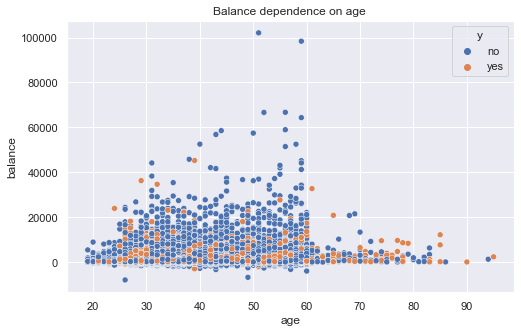

In [26]:
fig, (ax1) = plt.subplots(1, 1)
scatter_age_balance = sns.scatterplot(x = 'age',y='balance',data=df,hue='y')
fig.set_size_inches(8, 5)
plt.title('Balance dependence on age ')
plt.show()

There is no clear dependence of account balance on the customer's age. However, in general customers over the age of 60 and less than 20 years old seem to possess smaller account balances. This may be due to the fact the younger customers are in the process of establishing themsleves while the older customers have already retired and may not have any reliable source of income.

##### Negative balance customers
Let us check the subscription rate of customers with negative account balance.

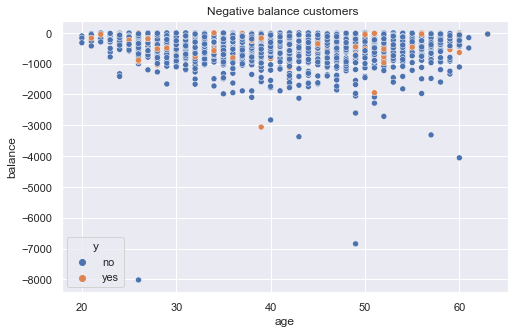

In [27]:
negative_balance_customers = df[df['balance'] < 0]
fig, (ax1) = plt.subplots(1, 1)
scatter_age_balance = sns.scatterplot(x = 'age',y='balance',data=negative_balance_customers,hue='y')
fig.set_size_inches(8, 5)
plt.title('Negative balance customers ')
plt.show()

There are non-negligible portion of customers who subscribed to the term deposit. Hence we can not drop these customers as outliers.

#### Duration and Campaign distribution

In [28]:
numerical_duration_campaign = ['duration', 'campaign']
print(stat_summary_numericals[['duration','campaign']].head(12))

        duration  campaign
count   40000.00  40000.00
mean      254.82      2.88
std       259.37      3.24
min         0.00      1.00
25%       100.00      1.00
50%       175.00      2.00
75%       313.00      3.00
max      4918.00     63.00
median    175.00      2.00


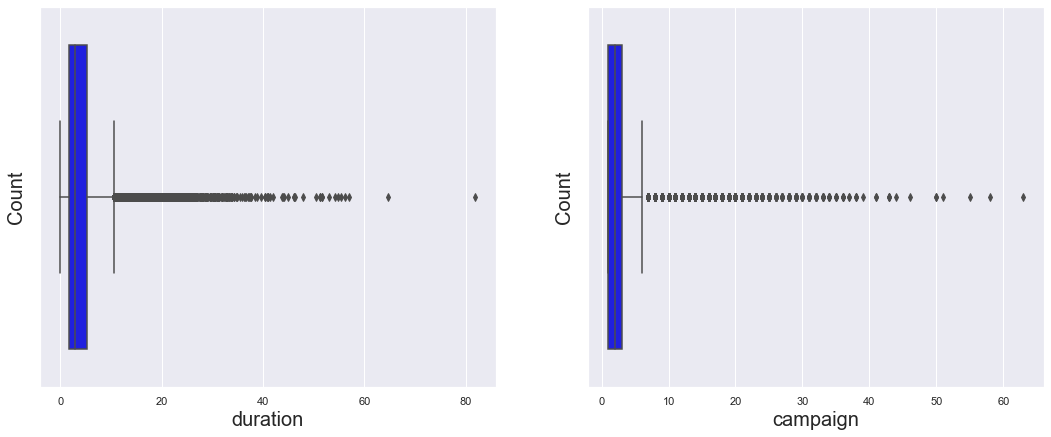

In [29]:
# Change duration unit to minutes from seconds
df['duration'] = df['duration'].apply(lambda n:n/60).round(2)
# plot histogram of duration and campaign
plot_distribution(df,numerical_duration_campaign);

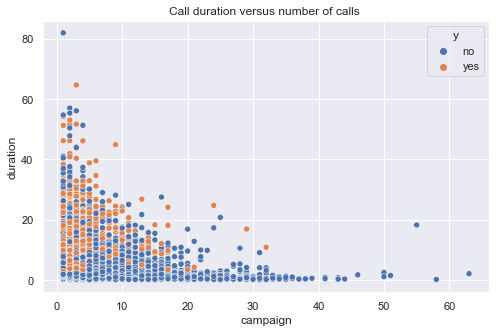

In [30]:
fig, (ax1) = plt.subplots(1, 1)
scatter_age_balance = sns.scatterplot(x = 'campaign',y='duration',data=df,hue='y')
fig.set_size_inches(8, 5)
plt.title('Call duration versus number of calls ')
plt.show()

Calls that lasted longer required fewer number of calls. It is more probable that a customer will decide whether to subscribe or not after a long conversation and no repeated calls were required. Also may some customers could have been busy at the time of the call and calls might be repeated before moving on with a decision. Also it is worth noting that the majority of customers who subscribed required less than 20 calls. Some outlier calls were repeated over 35 times, but no customers subscribed after the repeated calls. 

##### Day disbribution (last contact day of the month)

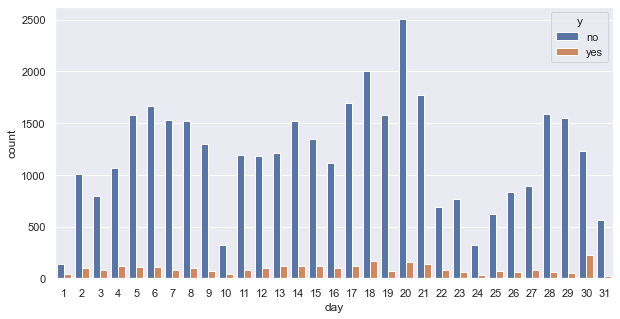

In [31]:
fig, (ax1) = plt.subplots(1, 1)
sns.countplot(x='day',data=df,hue='y')
fig.set_size_inches(10, 5)

Largest number of customer contacts were made in the middle 10 days of the month while the least number of contacts were made in the last 10 days of the month. Also the total number of customers who subscribed is the largest between 10-20 days of the month. There is a non-zero number of customers who subscribed for a given day within a month. 


#### Create new month, age, and balance group features

In [32]:
# Group months into seasons for easier analysis
winter = ['dec','jan','feb']
spring = ['mar','apr','may']
summer = ['jun','jul','aug']
fall = ['sep','oct','nov']
df.replace(winter,'winter [12-2]',inplace=True)
df.replace(spring,'spring [3-5]',inplace=True)
df.replace(summer,'summer [6-8]',inplace=True)
df.replace(fall,'fall [9-11]',inplace=True)
df['month'];

In [33]:
# Group customers based on their age and create a new feature called age_group
lst_df = [df]
for column in lst_df:
    column.loc[column["age"] < 35,  'age_group'] = '<35'
    column.loc[(column["age"] >= 35) & (column["age"] <= 50), 'age_group'] = '35-50'
    column.loc[(column["age"] > 50) & (column["age"] <= 65), 'age_group'] = '50-65'
    column.loc[(column["age"] > 65), 'age_group'] = '65+'
#    column.loc[column["age"] >= 60, 'age_group'] = 60

In [34]:
# Also let's group customers based on thier account balance as well and create new feature called balance_group.

lst_df = [df]
for column in lst_df:
    column.loc[column["balance"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 500), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 500) & (column["balance"] <= 3500), 'balance_group'] = 'avg balance'
    column.loc[(column["balance"] > 3500), 'balance_group'] = 'high balance'


In [35]:
# add newly added categorial features (age_group and balance_group) to our list of categorical features. 
categorical_features.append('age_group')
categorical_features.append('balance_group')
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'y',
 'age_group',
 'balance_group']

#### Age group and balance group

In [36]:
# Group data frame into two groups based on target value
df_group_by_target = df.groupby('y')
for target,df_group in df_group_by_target:
    if target == 'yes':
        df_subscribed = df_group
    if target == 'no':
        df_unsubscribed = df_group

In [37]:
#Dictionaries for age group, balance group, and season
dict_df_agegroup = create_df_sub(['age_group'])
dict_df_balancegroup = create_df_sub(['balance_group'])
dict_df_season = create_df_sub(['month'])
#dataframes for each category
df_agegroup = dict_df_agegroup['age_group']
df_balancegroup = dict_df_balancegroup['balance_group']
df_season = dict_df_season['month']
#Combine datframes
pd.concat([df_agegroup, df_balancegroup, df_season], keys=['Age Group', 'Balance Group', 'Season'],sort=True)

% Subscription  Not Subscribed  Subscribed  Total
Age Group     35-50                    6.39           18136        1238  19374
              <35                      8.60           11950        1124  13074
              50-65                    6.47            6944         480   7424
              65+                     42.19              74          54    128
Balance Group avg balance              8.35           13237        1206  14443
              low balance              6.37           13849         942  14791
              no balance               5.42            6564         376   6940
              high balance             9.72            3454         372   3826
Season        spring [3-5]             8.28           15141        1367  16508
              summer [6-8]             5.92           15363         966  16329
              winter [12-2]            8.44            3191         294   3485
              fall [9-11]              7.31            3409         269   3678

**Age group:** Though the total number of subscribers is the largest for customer in age range of 35-50, senior customers (65+) have the highest rate of subscription. And also the next highest rate of subscriptions is occurs in age range <35. Insight is that in future telemarketing campaing, the bank should concentrate more on seniors and young individuals. 

**Balance group:** Customer with the high balance in their bank account have the highest rate of subscription, while customers with no balance have the lowest rate of subscription. Customers with average balance in their account have also significant rate of subscription.

**Season:** The highest subscription occurs during spring and winter season due to spring being the tax season (customers have tax return money) and winter being the holiday and new year season (Customers are probably making new year resolution to invest)

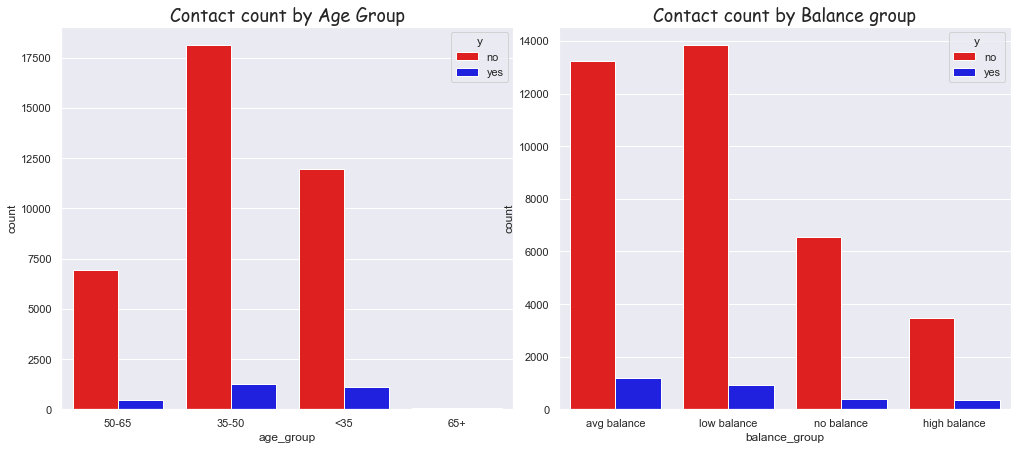

In [38]:
# plot distribution of customers per age group and balance group
age_and_balance_group = ['age_group','balance_group']

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 6)
        
plt.tight_layout()
            
sns.countplot(x= df['age_group'] , palette=['red','blue'], ax=ax1,hue=df['y'])
    
sns.countplot(x= df['balance_group'] , palette=['red','blue'], ax=ax2,hue=df['y'])
            
ax1.set_title('Contact count by Age Group',fontname='Comic Sans MS', fontsize=18)
                     
ax2.set_title('Contact count by Balance group',fontname='Comic Sans MS', fontsize=18);
            

#### Correlation of numerical features

In [39]:
# create new Target feature mapping 'yes':1 and 'no':0 from feature 'y'
df['Target'] = df['y'].map({'yes': 1, 'no': 0})

In [40]:
corr = df.corr()
#create an array of zeros like the corr dataframe
mask = np.zeros_like(corr)
#get indices of upper triangle of the mask array
triangle_indices = np.triu_indices_from(mask)
#assign upper traingle values of mask to True
mask[triangle_indices] = True

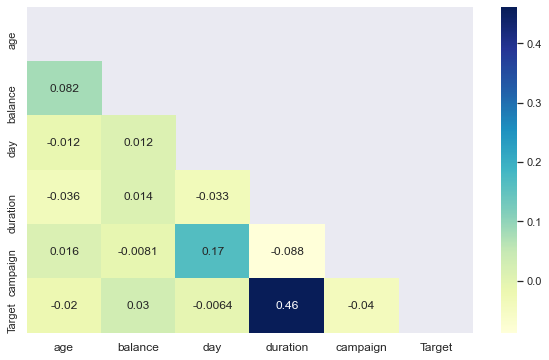

In [41]:
# set figure size
plt.figure(figsize=(10,6))
sns.heatmap(corr,mask=mask,annot=True,annot_kws={'size':12},cmap='YlGnBu')
plt.xticks(fontsize=12);

In [42]:
# Correlation significance is determined based on p-value = 0.005. 
corr[corr.Target >= 0.005].Target

balance    0.03
duration   0.46
Target     1.00
Name: Target, dtype: float64

Duration is highly positively correlated with target (Term deposit subscription) with a correlation value of 0.46, while balance the next feature that shows significant correlation with the Target. All other features are not significantly correlated with the Target. 

# END WRANGLING AND EDA
## Save clean and organized data

In [43]:
from library.sb_utils import save_file

In [44]:
df_temp = df.drop(columns=['age_group','balance_group'])
df.head()
# save the data to a new csv file
datapath = '../data'
save_file(df_temp, 'bank_data_cleaned.csv', datapath)
df_temp.head()

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\bank_data_cleaned.csv"


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,spring [3-5],4.35,1,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,spring [3-5],2.52,1,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,spring [3-5],1.27,1,no,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,spring [3-5],1.53,1,no,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,spring [3-5],3.30,1,no,0


# Preprocessing and data preparation for modeling
## Load the cleaned data set

In [45]:
# set a path variable to the directory containing cleaned data:. ../data
path = '../data'
# Concatenate directory path to the file name: bank_path
data_clean_path = path + '/bank_data_cleaned.csv'

# load clean dataset into a dataframe: df_clean
df_clean = pd.read_csv(data_clean_path)
# check the shape of our data
df_clean.shape

(40000, 15)

In [46]:
# Quick preview information of dataframe: 
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        40000 non-null  int64  
 1   job        40000 non-null  object 
 2   marital    40000 non-null  object 
 3   education  40000 non-null  object 
 4   default    40000 non-null  object 
 5   balance    40000 non-null  int64  
 6   housing    40000 non-null  object 
 7   loan       40000 non-null  object 
 8   contact    40000 non-null  object 
 9   day        40000 non-null  int64  
 10  month      40000 non-null  object 
 11  duration   40000 non-null  float64
 12  campaign   40000 non-null  int64  
 13  y          40000 non-null  object 
 14  Target     40000 non-null  int64  
dtypes: float64(1), int64(5), object(9)
memory usage: 4.6+ MB


## Remove features not related to customers

In this project our objective is to predict response of customers to future telemarketing campaign given a given set of customer information, features related to the campaign and other features not related directly to the customers themselves should be excluded when developing our predictive machine learning model. In our dataset, the feature relevant to the customers are the demographics (age,job,marital,education) and cucstomer financial data (default,balance,housing,loan). Only these 8 features and the response (target) variable should be considered when we develop our model. 

In [47]:
# create list of irrelevant features: feature_to_drop
#features_to_drop = ['campaign','month','day','y','contact']
features_to_drop = ['day','y']

In [48]:
# Drop irrelevant features
df_clean.drop(features_to_drop,axis=1, inplace=True)

In [49]:
# quickly preview of the dataframe.
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,spring [3-5],4.35,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,spring [3-5],2.52,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,spring [3-5],1.27,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,spring [3-5],1.53,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,spring [3-5],3.30,1,0


In [50]:
# Get overview information of our dataset
df_clean.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        40000 non-null  int64  
 1   job        40000 non-null  object 
 2   marital    40000 non-null  object 
 3   education  40000 non-null  object 
 4   default    40000 non-null  object 
 5   balance    40000 non-null  int64  
 6   housing    40000 non-null  object 
 7   loan       40000 non-null  object 
 8   contact    40000 non-null  object 
 9   month      40000 non-null  object 
 10  duration   40000 non-null  float64
 11  campaign   40000 non-null  int64  
 12  Target     40000 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 4.0+ MB


## Transforming categorical features to numerical

Machine learning algorithms do not work with categorical features. Only features with numberical values are employed by all machine learning algorithms. Hence, categorical features have to be transformed to numbers. As shown above our dataset consists of 7 categorical features. For example the feature `\hl{education}` consisted of text labels `{\color{blue} tertiary, secondary, primary, unknown}`. One may map the numbers 1, 2, 3, ,4 to each of the text labels of the feature and thereby transform the categorical feature to numerical feature called {\color{blue} \textbf{ordinal feature}}. At first, this kind of mapping may seem to make some sense with 1 corresponding to the highest educational level and 4 to the lowest level. Nevertheless, when in employed in a machine learning model it will be treated just like any other numerical. Specifically, for models that seek to find a linear relationship between features and response the encoding might might lead to undesirable effect. Depending on how linear the relationship of the features and the response variable, such ordinal encoding might work well or not. Nevertheless, the limitation imposed by ordinal transformation could be avoided by the use of another versatile and popular method of categorical encoding called one-hot encoding (OHE). 

One-hot encoding (OHE) is a way to encode categorical features without intoducing unintended feature/response relationships like an ordinal encoding, by expanding the categorical feature into as many new features as the number of distinct feature values. For example, in our case OHE will split the feature `\hl{education}` into 4 columns corresponding to the number of text labels. Every row will have a value equal to '1' in exactly one column and a '0' elsewhere.   

It must be noted that in the case of a categorical feature with at most 2 unique values, the use of of ordinal encoding is justified as two points always define a straight line. Hence, any model including a model that seeks a linear relationship should work well. 

In [51]:
# transform two valued categorical features with ordinal encoding
df_clean['housing'] = df_clean['housing'].map({'yes': 1, 'no': 0})
df_clean['default'] = df_clean['default'].map({'yes': 1, 'no': 0})
df_clean['loan'] = df_clean['loan'].map({'yes': 1, 'no': 0})
df_clean.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,Target
0,58,management,married,tertiary,0,2143,1,0,unknown,spring [3-5],4.35,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,spring [3-5],2.52,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,spring [3-5],1.27,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,spring [3-5],1.53,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,spring [3-5],3.30,1,0


In [52]:
# One hot encode the remaining three categorical features
df_final = pd.get_dummies(df_clean,drop_first=True)

In [53]:
# quick view of the dataset
df_final.head()

,age,default,balance,housing,loan,duration,campaign,Target,job_blue-collar,job_entrepreneur,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_spring [3-5],month_summer [6-8],month_winter [12-2]
0,58,0,2143,1,0,4.35,1,0,0,0,...,1,0,0,1,0,0,1,1,0,0
1,44,0,29,1,0,2.52,1,0,0,0,...,0,1,1,0,0,0,1,1,0,0
2,33,0,2,1,1,1.27,1,0,0,1,...,1,0,1,0,0,0,1,1,0,0
3,47,0,1506,1,0,1.53,1,0,1,0,...,1,0,0,0,1,0,1,1,0,0
4,33,0,1,0,0,3.30,1,0,0,0,...,0,1,0,0,1,0,1,1,0,0


In [54]:
# Check that all features are now numerical
df_final.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 29 entries, age to month_winter [12-2]
dtypes: float64(1), int64(7), uint8(21)
memory usage: 3.2 MB


In [55]:
# shift the feature named 'Target' to be the first column in the dataframe
first_column = df_final.pop('Target');

In [56]:
df_final.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 28 entries, age to month_winter [12-2]
dtypes: float64(1), int64(6), uint8(21)
memory usage: 2.9 MB


In [57]:
# insert column using insert(position,column_name,
# first_column) function
df_final.insert(0, 'Target', first_column)

In [58]:
df_final.head()

,Target,age,default,balance,housing,loan,duration,campaign,job_blue-collar,job_entrepreneur,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_spring [3-5],month_summer [6-8],month_winter [12-2]
0,0,58,0,2143,1,0,4.35,1,0,0,...,1,0,0,1,0,0,1,1,0,0
1,0,44,0,29,1,0,2.52,1,0,0,...,0,1,1,0,0,0,1,1,0,0
2,0,33,0,2,1,1,1.27,1,0,1,...,1,0,1,0,0,0,1,1,0,0
3,0,47,0,1506,1,0,1.53,1,1,0,...,1,0,0,0,1,0,1,1,0,0
4,0,33,0,1,0,0,3.30,1,0,0,...,0,1,0,0,1,0,1,1,0,0


## Select dependent and independent features
The first column named `Target` represent the outcome of the campaign and is selected as our independent feature while remaining 21 columns, which containg customer information are selected as dependent features. 

In [59]:
# dependent and independent features
X = df_final.iloc[:,1:]
y = df_final.iloc[:,0]

In [60]:
# check the shape of dependent and independent features
X.shape, y.shape

((40000, 28), (40000,))

#### Scale the data

As we have features measured in many different units, with numbers that vary by orders of magnitude, start off by scaling them to put them all on a consistent scale. The StandardScaler scales each feature to zero mean and unit variance.

In [61]:
# Scale the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

## Properly set the random seed for ML

Machine learning models make use of randomness in obvious and unexpected ways. At a conceptual level, this non-determinism may impact your model’s convergence rate, the stability of your results, and the final quality of a network.

At a practical level, it means that you probably have difficulty reproducing the same results across runs for your model — even when you run the same script on the same training data. It could also lead to challenges in figuring out whether a change in performance is due to an actual model or data modification, or merely the result of a new random sample.

### Where does randomness appear?
**1. Data preparation:** in the case of a neural network, the shuffled batches will lead to different loss values across runs. This means your gradient values will be different across runs, and you will probably converge to a different local minima For specific types of data like time-series, audio, or text data plus specific types of models like LSTMs and RNNs, your data’s input order can dramatically impact model performance.

**2. Data pre-processing:** Over or upsampling data when dealing with imbalanced dataset

**3. Cross Validation:** Both K-fold and leave one out cross validation (LOOCV)

**4. Weight initialization:** Weights often set randomly to [-1,1] or [0,1]

**5. Hidden layers:** Drop out layers randomly ignore subset of nodes

**6. Algorithms themselves:** Some models, such as Random Forest operate inherently on random selection


### Achieving Reproducibility (Dealing with the random problem)

To deal with the random problem (reproducibility problem) we follow the following steps.

In [62]:
# 1. set random seed value
seed_value = 47

os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

## Train/test split the data
In order to assess the predictive power of machine learning models it is important to split the data before training the model. The data split labeled as train is used to train the model, while the test split is reserved to assess the performance of the developed model. We splitted our dataset with train/test ratio of 80:20. 

In [63]:
# split the dataset into train/test split
test_size= 0.20
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=test_size, random_state=seed_value)

# Machine learning Modeling

## Lazy predict and Initial model selection .

Lazy Predict helps build a lot of basic models without much code and helps understand which models works better without any parameter tuning.

Free software: MIT license
Documentation: https://lazypredict.readthedocs.io.

In [64]:
lzy_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None,random_state=seed_value)
lzy_models,predictions = lzy_clf.fit(X_train, X_test, y_train, y_test)

print(lzy_models)
print(type(lzy_models))


100%|██████████| 29/29 [10:49<00:00, 22.41s/it] 

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.88               0.82     0.82      0.90   
QuadraticDiscriminantAnalysis      0.91               0.71     0.71      0.91   
GaussianNB                         0.90               0.70     0.70      0.90   
LinearDiscriminantAnalysis         0.93               0.69     0.69      0.93   
PassiveAggressiveClassifier        0.90               0.67     0.67      0.90   
DecisionTreeClassifier             0.91               0.67     0.67      0.91   
XGBClassifier                      0.93               0.65     0.65      0.92   
LGBMClassifier                     0.94               0.65     0.65      0.93   
LabelSpreading                     0.92               0.65     0.65      0.91   
AdaBoostClassifier                 0.93               0.65     0.65      0.92   
LabelPropagation            

In [65]:
lzy_models['F1 Score_vs_time'] = lzy_models['F1 Score']/lzy_models['Time Taken']
lzy_models;

In [66]:
lzy_models[['F1 Score','F1 Score_vs_time']].sort_values(by='F1 Score',ascending=False)

,F1 Score,F1 Score_vs_time
Model,,
LinearDiscriminantAnalysis,0.93,2.05
LGBMClassifier,0.93,1.57
XGBClassifier,0.92,0.46
AdaBoostClassifier,0.92,0.49
BaggingClassifier,0.92,0.63
RandomForestClassifier,0.92,0.17
CalibratedClassifierCV,0.92,0.04
LogisticRegression,0.92,2.55
ExtraTreesClassifier,0.92,0.26


In [67]:
lzy_models['AUC Score_vs_time'] = lzy_models['ROC AUC']/lzy_models['Time Taken']
lzy_models;

In [68]:
lzy_models[['ROC AUC','AUC Score_vs_time']].sort_values(by='ROC AUC',ascending=False)

,ROC AUC,AUC Score_vs_time
Model,,
NearestCentroid,0.82,3.81
QuadraticDiscriminantAnalysis,0.71,2.89
GaussianNB,0.70,6.65
LinearDiscriminantAnalysis,0.69,1.53
PassiveAggressiveClassifier,0.67,2.47
DecisionTreeClassifier,0.67,2.55
XGBClassifier,0.65,0.32
LGBMClassifier,0.65,1.11
LabelSpreading,0.65,0.00


Based on time and accuracy, the best performing three models are `BaggingClassifier`, `XGBClassifier`, `KNeighborsClassifier`, `LogisticRegression`, and `RandomForestClassifier`

Now that we have prepared our dataset in the form that could be used by any machine learning algorith, in this chapter we will train a number of classification machine learning alogorithms with grid search parameter optimization and cross validation for evaluation during the training stage. Best perfoming model selected based an appropriate model metric will be tested with the test set of our data set which was held back during model training. 

##### Classification models

The following list maching learning classification models will be tested.

- Logistic regression
- BaggingClassifier
- Random Forest
- Extreme Gradient boosting
- K-neighbourhood classifier

In [69]:
# Create a list containing the classification models to be used. 
models_list = []
models_list.append(('LR', LogisticRegression(random_state=seed_value)))
models_list.append(('KNN', KNeighborsClassifier()))
models_list.append(('BAGCLF', BaggingClassifier(random_state=seed_value)))
models_list.append(('XGBOOST',XGBClassifier()))
models_list.append(('RF',RandomForestClassifier(random_state=seed_value)))

## K-fold training data split and cross-validation

Cross validation is an essential technique when using the training data. It opens up a better of use the training data set through multiple model evaluation (K-fold) during the training phase. It involves K-fold splitting of the training dataset where the training dataset is randomly split into K-folds or groups. During the training the first fold is kept for testing while the remaining `K-1` group are used for training. The training is repeated k times and each time a different split group is used for validation. However, it is worth noting that each fold should be a good representative of the whole training dataset. `Stratified K-fold` attempts to solve this issue by preserving class ratio when fold groups are created. 



In [70]:
# function for selecting a stratified or normal K-Fold depending on the value of is_stratified
    
def get_cross_validation_splitter(is_strattified=False):
    kfold= None
    if(not is_strattified):
        kfold = KFold(n_splits=5,shuffle=True, random_state=seed_value)
    else:
        kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=seed_value)
            
    return kfold

In [71]:
# call validation splitter function above
# return value of function SHOULD be assigned to variable kfold
kfold = get_cross_validation_splitter()

In [72]:
# get stratified Kfold
kfoldstratified = get_cross_validation_splitter(is_strattified=True)

In [73]:
# Create dictionary containing model metrics
model_scores = {'Accuracy':'accuracy','Recall':'recall','Precision':'precision','f1-score':'f1',
                'AUC':'roc_auc'}
#model_scores = {'AUC':'roc_auc'}

### Model Selection With K-fold Cross Validation
There are lots of models available today, easy to implement with tons of built-in library supports, from simple to complex mathematical calculations all performed by just calling the name of a function. Gradient Boosting, Logistic regression, SVMs, all just happens to be there to help you, just call for it. Looking at the bright side, we are presented with lots of options with no need to write complex code for mathematical calculations, but look again and with a big problem statement and a bigger dataset in hand, you will see that more choices mean more headache.

The choice of a model can be broken down to some extent by understanding the problem and the data you are presented with. But What model to choose and which will give more optimal result is always a Data Scientist’s most self asked question and high variance in predictions with the same model is a Data Scientist’s worst nightmare.

`K-Fold Cross-validation` is used to find out which model best fits a given data set and has a higher probability of giving a better accuracy on predictions.

The above write up by AMAL NAIR which can be found from https://analyticsindiamag.com/k-fold-cross-validation-a-walkthrough-with-machinehacks-food-cost-prediction-hackathon/

In [74]:
# function to create model performance and return a dataframe of model performances.
def create_model_performance(x=X_train,y=y_train,models=models_list):
    model_names = []

    dict_model_performance = {}
    for name, model in models:
        results_c = []
        results_dict = {}
        model_sel = model
#        model_sel.fit(X_train,y_train)
        for score_name, score in model_scores.items():
# define how to split off validation data ('kfold' how many folds)
#        kfold = KFold(n_splits=5, random_state=Iseed)    
# train the model
#            model_sel = model
#            model_sel.fit(X_train,y_train)
            cv_results = cross_val_score(estimator=model_sel,X=X_train, y=y_train, cv=kfold, scoring=score)   
            results_c.append(cv_results)
            model_names.append(name)
#            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            results_dict[score_name] = float(round(cv_results.mean(),2))
#    print(msg)
        dict_model_performance[name] = results_dict
    model_performance_df = pd.DataFrame(dict_model_performance)
    return model_performance_df

In [75]:
def create_single_metric(x=X_train,y=y_train,models=models_list,score='roc_auc'):
    model_names = []

    dict_model_performance = {}
    for name, model in models:
        results_c = []
        results_dict = {}
        model_sel = model
#        model_sel.fit(X_train,y_train)
#        for score_name, score in model_scores.items():
# define how to split off validation data ('kfold' how many folds)
#        kfold = KFold(n_splits=5, random_state=Iseed)    
# train the model
#            model_sel = model
#            model_sel.fit(X_train,y_train)
        cv_results = cross_val_score(estimator=model_sel,X=X_train, y=y_train, cv=kfold, scoring=score)   
        results_c.append(cv_results)
        model_names.append(name)
#            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        results_score = float(round(cv_results.mean(),2))
#    print(msg)
        dict_model_performance[name] = cv_results
    model_performance_df = pd.DataFrame(dict_model_performance)
    return model_performance_df

In [76]:
model_performance_regular_kfold_df = create_model_performance()
print('Regular K-fold: Model Evaluation Metrics')
model_performance_regular_kfold_df.head(12)

Regular K-fold: Model Evaluation Metrics


,LR,KNN,BAGCLF,XGBOOST,RF
Accuracy,0.93,0.93,0.93,0.93,0.93
Recall,0.23,0.20,0.25,0.30,0.24
Precision,0.60,0.51,0.49,0.51,0.55
f1-score,0.33,0.28,0.34,0.38,0.33
AUC,0.90,0.78,0.86,0.92,0.91


In [77]:
model_AUC_regular_kfold_df = create_single_metric()

In [78]:
# Create stratified k-fold split with is_stratified = True
kfold = get_cross_validation_splitter(is_strattified=True)

In [79]:
model_AUC_stratified_kfold_df = create_single_metric()

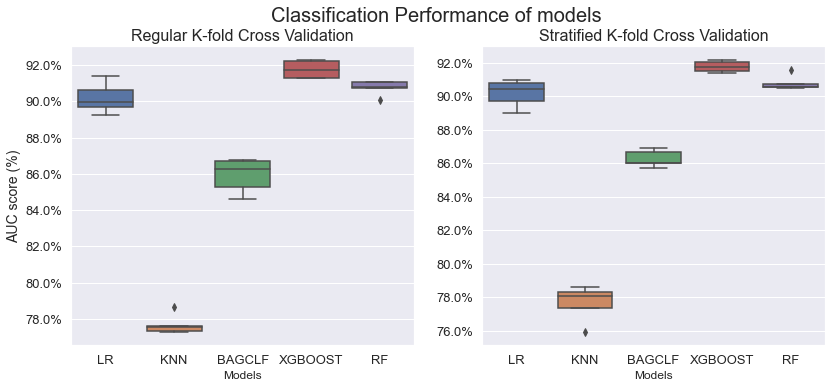

In [80]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(13.5, 5.5)
fig.suptitle('Classification Performance of models',fontsize=20)
sns.boxplot(x='variable', y='value',data=pd.melt(model_AUC_regular_kfold_df),ax=ax1)
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('AUC score (%)', fontsize=14)
ax1.set_title('Regular K-fold Cross Validation',fontsize=16)
sns.boxplot(x='variable', y='value',data=pd.melt(model_AUC_stratified_kfold_df),ax=ax2)
ax2.set_title('Stratified K-fold Cross Validation',fontsize=16)
ax2.set_xlabel('Models', fontsize=12)
ax2.set_ylabel('', fontsize=14)
ax2.tick_params(axis='both',labelsize=13)
ax1.tick_params(axis='both',labelsize=13)
y_value1=['{:,.1f}'.format(100*x) + '%' for x in ax1.get_yticks()]
ax1.set_yticklabels(y_value1)
y_value2=['{:,.1f}'.format(100*x) + '%' for x in ax2.get_yticks()]
ax2.set_yticklabels(y_value2);

### The imbalanced data set problem
Clearly our data set is imbalanced and we have to resample it before model training. The impacts of imbalanced data are implicit, i.e. it does not raise an immediate error when you build and run your model, but the results can be delusive.

#### How to deal with imbalanced data?
Several solutions have been suggested in the literature to address this problem, amongst which are:

- `Data-level techniques` — At the data level, solutions work by applying resampling techniques to balance the dataset. These can be done by oversampling the minority class, which is to synthetically create new instances from existing ones; or undersampling the majority class, which eliminates some instances in the majority class. However, both techniques can have their drawbacks. Oversampling new data can cause the classifier to overfit; whereas undersampling can discard essential information. A combination of both techniques with a heuristic approach can be found in specialized literature with excellent results.

- `Algorithmic-level techniques` —Algorithmic level solutions can be done by adjusting weighted costs accordingly to the number of training instances in each class. In parametric classifier like Support Vector Machine, grid search and cross-validation can be applied to optimise the C and gamma values. For non-parametric classifier like the decision tree, adjusting the probabilistic estimate at the tree leaf can improve the performance.

- `A combination of both` — A hybrid approach is also constantly being explored in various literature, including AdaOUBoost (adaptive over-sampling and undersampling boost) proposed by Peng and Yao and Learning By Recognition, using the concept of auto association-based classification approach proposed by Japkowicz.

#### Dealing with imbalanced data in Python
One of the most popular libraries for sampling methods in Python is none other than the imbalanced-learn package. It provides several methods for both over- and undersampling, as well as some combinational methods. For this tutorial, we will explore one example for each of these 3 methods:

- `Random undersampling` with `RandomUnderSampler`
- `Oversampling` with `SMOTE` (Synthetic Minority Over-sampling Technique)
A combination of both random undersampling and oversampling using pipeline

Reference for this notes are from a write up by Jack tan. The link is here (https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb)

In [81]:
# Apply the SMOTE oversampling method for handling the data imbalance
sm = SMOTE(sampling_strategy='auto')
X_res, y_res = sm.fit_resample(X_train, y_train)

In [82]:
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 29690, 1: 2310})
Resampled dataset shape Counter({0: 29690, 1: 29690})


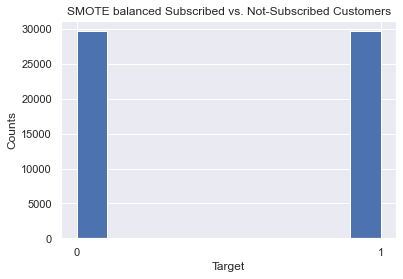

In [83]:
plt.hist(y_res)
plt.xticks([0,1])
plt.title('SMOTE balanced Subscribed vs. Not-Subscribed Customers')
plt.xlabel("Target")
plt.ylabel("Counts");

In [84]:
model_performance_df_balanced = create_model_performance(x=X_res,y=y_res)
print('Balanced dataset: Model Evaluation Metrics')
model_performance_df_balanced.head(12)

Balanced dataset: Model Evaluation Metrics


,LR,KNN,BAGCLF,XGBOOST,RF
Accuracy,0.93,0.93,0.93,0.93,0.93
Recall,0.23,0.19,0.25,0.31,0.24
Precision,0.59,0.51,0.49,0.53,0.55
f1-score,0.33,0.28,0.33,0.39,0.34
AUC,0.90,0.78,0.86,0.92,0.91


In [85]:
kfold = get_cross_validation_splitter()

In [86]:
model_performance_regular_kfold_df_balanced = create_model_performance(x=X_res,y=y_res)
print('Balanced dataset: Model Evaluation Metrics')
model_performance_regular_kfold_df_balanced.head(12)

Balanced dataset: Model Evaluation Metrics


,LR,KNN,BAGCLF,XGBOOST,RF
Accuracy,0.93,0.93,0.93,0.93,0.93
Recall,0.23,0.20,0.25,0.30,0.24
Precision,0.60,0.51,0.49,0.51,0.55
f1-score,0.33,0.28,0.34,0.38,0.33
AUC,0.90,0.78,0.86,0.92,0.91


1. Plot the confusion matrix
2. Scaling and normalization
3. Print the performance on the training and the test set
4. Use regularization techniques

# Confustion Matrix
## Imbalanced dataset

In [87]:
# define a function for generating modeles
def models(x=X_train,y=y_train):
        #logistic regression
        log = LogisticRegression(random_state=seed_value)
        log.fit(x,y)
        #Kneighbors
        knn = KNeighborsClassifier()
        knn.fit(x,y)
        #Random Forest
        forest = RandomForestClassifier(random_state=seed_value)
        forest.fit(x,y)
        #BaggingClassifier
        bagclf = BaggingClassifier(random_state=seed_value)
        bagclf.fit(x,y)
        #XGBoostClassifier
        xgb = XGBClassifier()
        xgb.fit(x,y)
        #print the models accuracy
        print('[0] Logistic Regression f1 score: ', f1_score(y,log.predict(x)))
        print('[0] Kneighbors f1 score: ', f1_score(y,knn.predict(x)))
        print('[0] Random Forest f1 score: ', f1_score(y,forest.predict(x)))
        print('[0] BaggingClassifier f1 score: ', f1_score(y,bagclf.predict(x)))
        print('[0] XGBoost f1 score: ', f1_score(y,xgb.predict(x)))
        return log,knn,forest,bagclf,xgb

model = models(x=X_train,y=y_train)

[0] Logistic Regression f1 score:  0.3344752413578324
[0] Kneighbors f1 score:  0.4622725917089174
[0] Random Forest f1 score:  0.9997835029227106
[0] BaggingClassifier f1 score:  0.9479166666666666
[0] XGBoost f1 score:  0.7061288632792037


In [88]:
# Confusion Matrix on train data set
def plot_confusion_matrix(x=X_train,y=y_train,model=model,data='train'):
    
    for i in range(len(model)):
        model_label = str(model[i]).split('(')
        cm = confusion_matrix(y,model[i].predict(x))
        print('Model: ',model_label[0])
        if i==0:
            heatmap(cm, annot=True, fmt="g", yticklabels=["Not Subscribed", "Subscribed"] ,
                xticklabels=["Not Subscribed", "Subscribed"],cmap="YlGnBu",linewidths=2.5)
            plt.title("Confusion matrix for {}-dataset".format(data) +  "\n"  + "Model: " + model_label[0])
            plt.xlabel("Predicted")
            plt.ylabel("Expected")
            plt.show()
        elif i == 1:
            heatmap(cm, annot=True, fmt="g", yticklabels=["Not Subscribed", "Subscribed"] ,
                xticklabels=["Not Subscribed", "Subscribed"],cmap="YlGnBu")
            plt.title("Confusion matrix for {}-dataset".format(data) +  "\n"  + "Model: " + model_label[0])
            plt.xlabel("Predicted")
            plt.ylabel("Expected")
            plt.show()
        else:
            heatmap(cm, annot=True, fmt="g", yticklabels=["Not Subscribed", "Subscribed"] ,
                xticklabels=["Not Subscribed", "Subscribed"],cmap="YlGnBu")
            plt.title("Confusion matrix for {}-dataset".format(data) +  "\n"  + "Model: " + model_label[0])
            plt.xlabel("Predicted")
            plt.ylabel("Expected")
            plt.show()

Confusion Matrix Plots: Training dataset

Model:  LogisticRegression


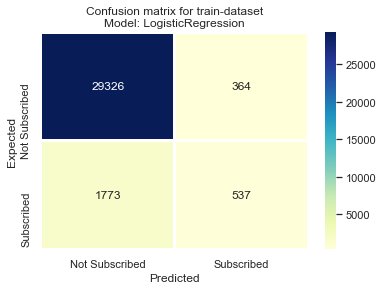

Model:  KNeighborsClassifier


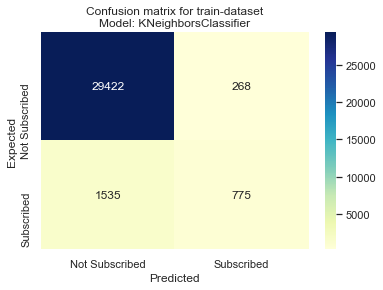

Model:  RandomForestClassifier


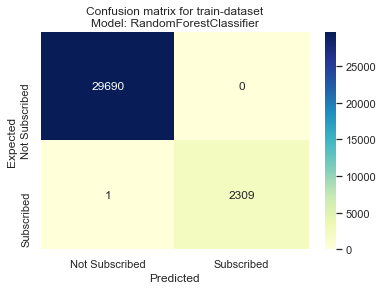

Model:  BaggingClassifier


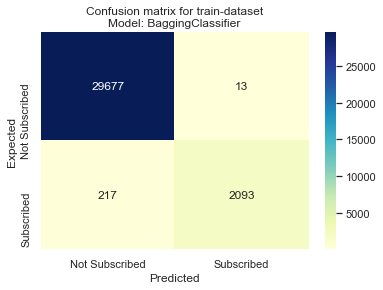

Model:  XGBClassifier


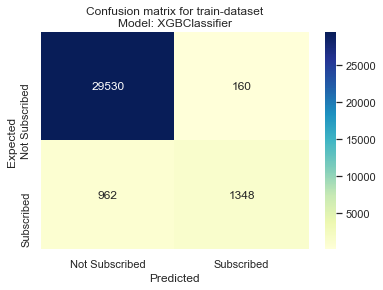

In [89]:
# Plot confusion matrix on training data
print('Confusion Matrix Plots: Training dataset\n')
plot_confusion_matrix()

Confusion Matrix Plots: Test dataset

Model:  LogisticRegression


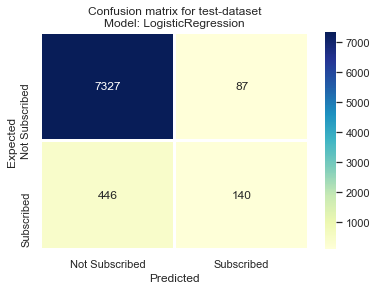

Model:  KNeighborsClassifier


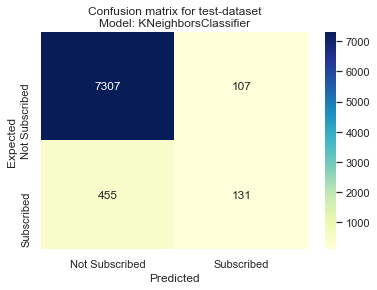

Model:  RandomForestClassifier


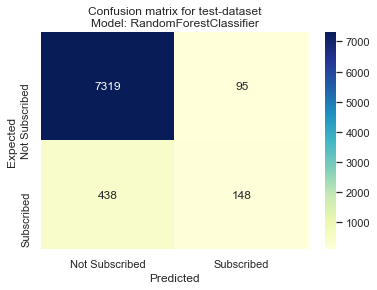

Model:  BaggingClassifier


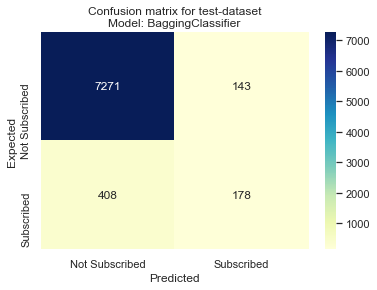

Model:  XGBClassifier


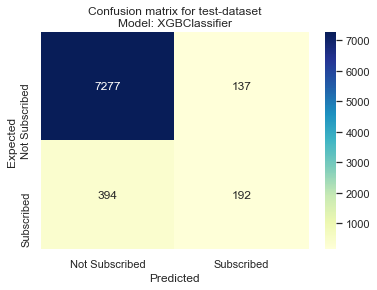

In [90]:
# Plot confusion matrix on training data
print('Confusion Matrix Plots: Test dataset\n')
plot_confusion_matrix(x=X_test,y=y_test,data='test')

## Balanced dataset

In [91]:
model_balanced = models(x=X_res,y=y_res)

[0] Logistic Regression f1 score:  0.850030481609429
[0] Kneighbors f1 score:  0.9552494307262479
[0] Random Forest f1 score:  1.0
[0] BaggingClassifier f1 score:  0.9974551276649533
[0] XGBoost f1 score:  0.9757726802638048


Confusion Matrix Plots: Balanced Training dataset

Model:  LogisticRegression


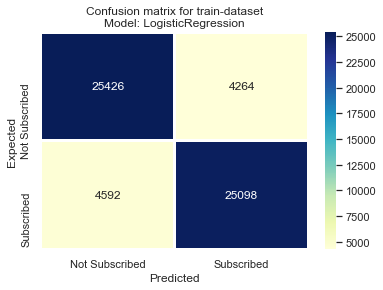

Model:  KNeighborsClassifier


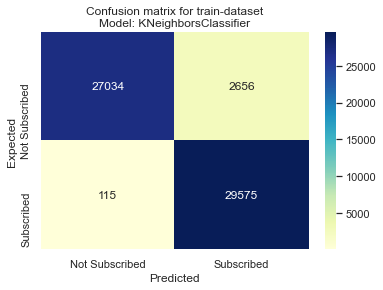

Model:  RandomForestClassifier


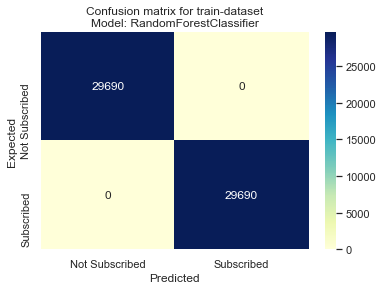

Model:  BaggingClassifier


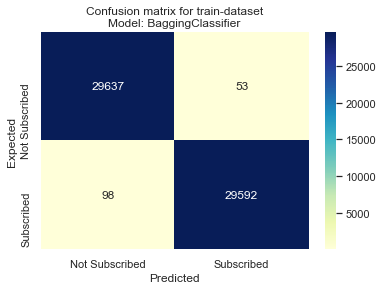

Model:  XGBClassifier


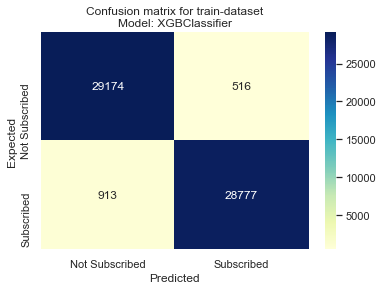

In [92]:
# Plot confusion matrix on training data
print('Confusion Matrix Plots: Balanced Training dataset\n')
plot_confusion_matrix(x=X_res,y=y_res,model=model_balanced,data='train')

Confusion Matrix Plots: Balanced test dataset

Model:  LogisticRegression


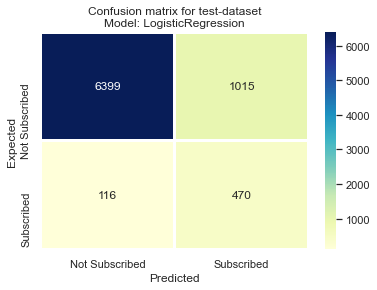

Model:  KNeighborsClassifier


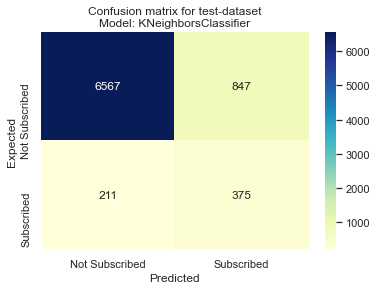

Model:  RandomForestClassifier


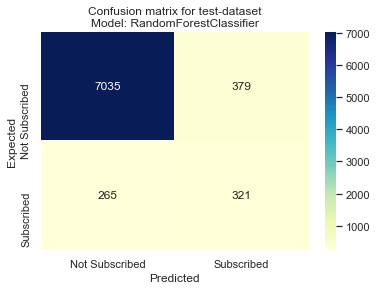

Model:  BaggingClassifier


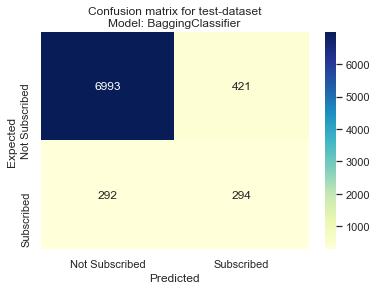

Model:  XGBClassifier


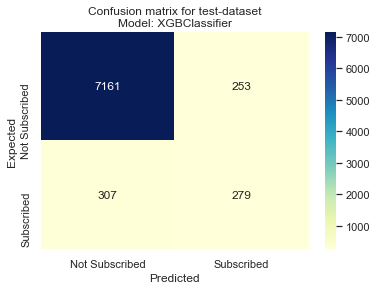

In [93]:
# Plot confusion matrix on training data
print('Confusion Matrix Plots: Balanced test dataset\n')
plot_confusion_matrix(x=X_test,y=y_test,model=model_balanced,data='test')

# Undersampling

In [94]:
rus = RandomUnderSampler(random_state=seed_value)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)

In [95]:
print(sorted(Counter(y_undersampled).items()))

[(0, 2310), (1, 2310)]


In [96]:
model_undersampled = models(x=X_undersampled,y=y_undersampled)

[0] Logistic Regression f1 score:  0.8286975717439294
[0] Kneighbors f1 score:  0.8555846422338568
[0] Random Forest f1 score:  1.0
[0] BaggingClassifier f1 score:  0.9871767007172354
[0] XGBoost f1 score:  0.9829336789803413


Confusion Matrix Plots: Undersampled Training dataset

Model:  LogisticRegression


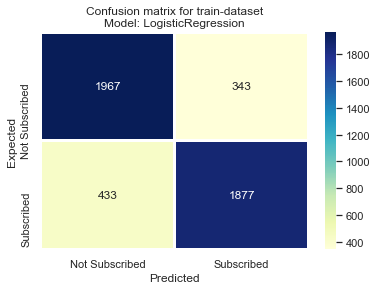

Model:  KNeighborsClassifier


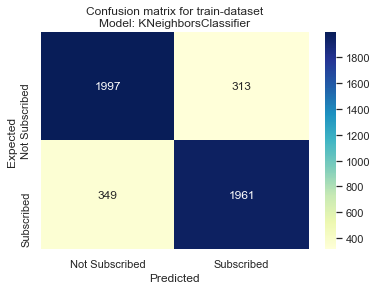

Model:  RandomForestClassifier


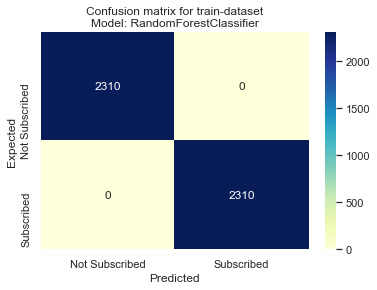

Model:  BaggingClassifier


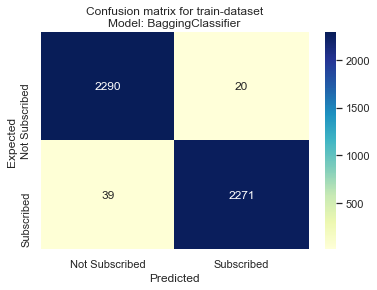

Model:  XGBClassifier


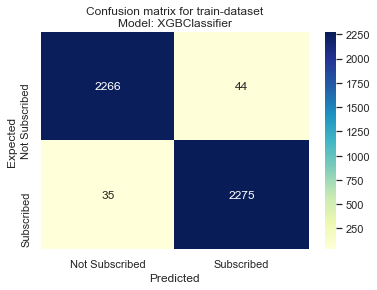

In [97]:
# Plot confusion matrix on training data
print('Confusion Matrix Plots: Undersampled Training dataset\n')
plot_confusion_matrix(x=X_undersampled,y=y_undersampled,model=model_undersampled,data='train')

## Test split dataset

In [98]:
print('[0] Logistic Regression f1 score: ', f1_score(y_test,model_undersampled[0].predict(X_test)))
print('[0] Kneighbors f1 score: ', f1_score(y_test,model_undersampled[1].predict(X_test)))
print('[0] Random Forest f1 score: ', f1_score(y_test,model_undersampled[2].predict(X_test)))
print('[0] BaggingClassifier f1 score: ', f1_score(y_test,model_undersampled[3].predict(X_test)))
print('[0] XGBoost f1 score: ', f1_score(y_test,model_undersampled[4].predict(X_test)))

[0] Logistic Regression f1 score:  0.4463276836158192
[0] Kneighbors f1 score:  0.36478984932593184
[0] Random Forest f1 score:  0.4496883348174533
[0] BaggingClassifier f1 score:  0.44157002676181983
[0] XGBoost f1 score:  0.43809523809523815


Confusion Matrix Plots: Undersampled Test dataset

Model:  LogisticRegression


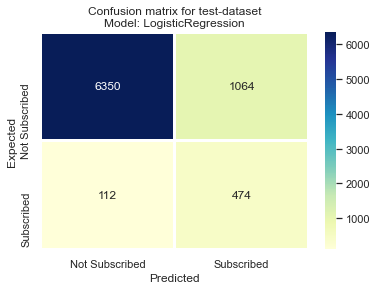

Model:  KNeighborsClassifier


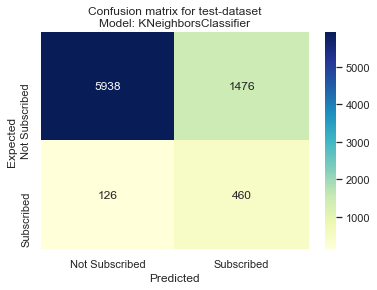

Model:  RandomForestClassifier


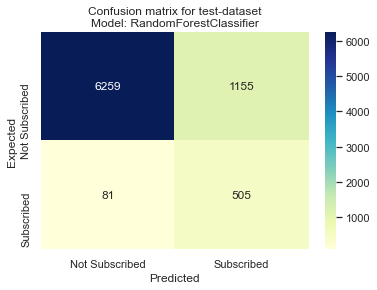

Model:  BaggingClassifier


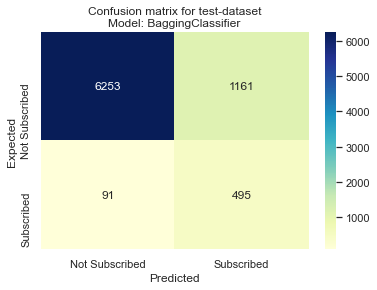

Model:  XGBClassifier


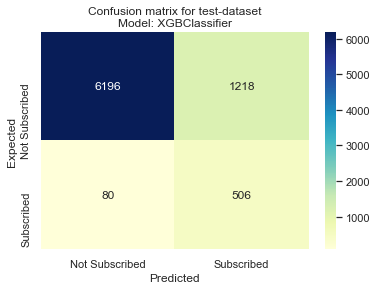

In [99]:
# Plot confusion matrix on training data
print('Confusion Matrix Plots: Undersampled Test dataset\n')
plot_confusion_matrix(x=X_test,y=y_test,model=model_undersampled,data='test')